In [1]:
%pylab inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
from os import listdir

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_data(name):
    data = []
    for line in open(name, 'r'):
        spl = line.split('|')
        date, users = datetime.datetime.strptime(spl[1].strip(), "%Y-%m-%d"), int(spl[3].split(' ')[1].replace(',', ''))
        data.append([date, users])

    return array(data)

In [3]:
def plot_data(data, legend = None):
    plot(range(len(data)), data[:,1], label = legend)
    xticks(range(len(data)), [x.strftime("%d-%m") for x in data[:,0]],  rotation=70)

In [4]:
DATA_DIR = 'data/'
dirs = listdir(DATA_DIR)
dirs

['15-05', '09-04']

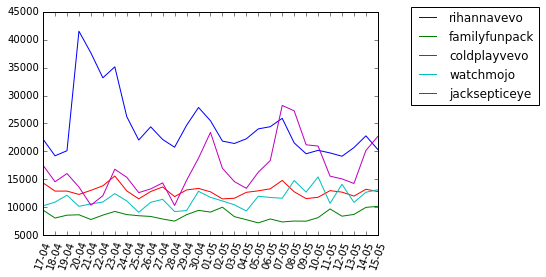

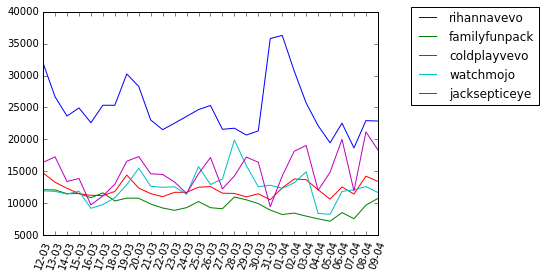

In [5]:
convert_dir = lambda _dir: DATA_DIR + _dir + '/'
contents = lambda _dir: set(listdir(convert_dir(_dir)))

names = ['rihannavevo', 'familyfunpack', 'coldplayvevo', 'watchmojo', 'jacksepticeye']
# list(contents(dirs[0]) & contents(dirs[1]))[:5]
data = {}
for name in names:
    data[name] = []
for _dir in dirs:
    directory = convert_dir(_dir)
    for name in names:
        datum = read_data(directory + name)
        plot_data(datum, legend=name)
        data[name].append(datum)
    legend(bbox_to_anchor=(1.5, 1.05))
    show()

In [11]:
from prediction import Prediction

In [12]:
def plot_results(predict_fn, data_set):
    data = []
    miss= 0
    for i in range(len(data_set)):
        var = data_set[i]
        test_batch = var[:, :-1]
        prediction = predict_fn(test_batch)
        data.append([2*i, var[0, -1]-1, prediction[0]-1])
        if var[0, -1] == prediction[0]:
            miss += 1
        data.append([2*i+1, 0,0])
    data = array(data)
    figure(figsize=(12,6))
    plot(data[:, 0], data[:, 1], label='expected', color='r')
    plot(data[:, 0], data[:, 2], label='computed', color='b')
    legend()
    print("Accuracy: %g" % (miss/len(data_set)))

In [13]:
p = Prediction(data['coldplayvevo'])
p.train()

100%|██████████| 2000/2000 [00:07<00:00, 283.53it/s]


In [14]:
train, test, predict_fn = p.network_attributes()

Accuracy: 0.923077


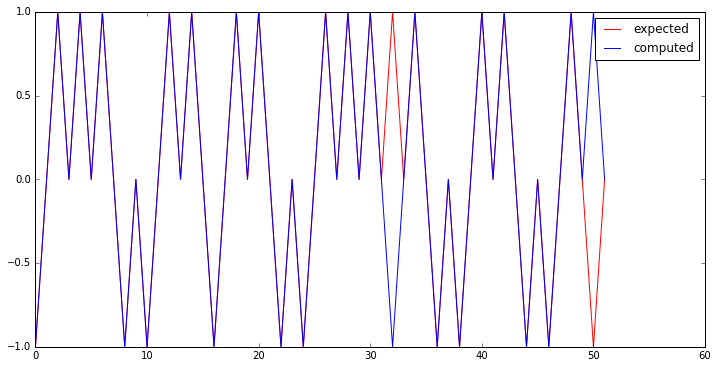

In [15]:
plot_results(predict_fn, train)

Accuracy: 0.538462


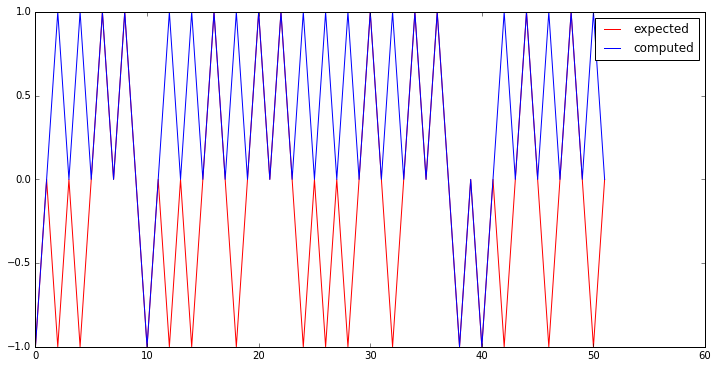

In [16]:
plot_results(predict_fn, test)